In [2]:
# Load some libraries for reading the data from the database and plotting 

import django
import sys, os
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *
from tmv_app.models import *

from django.db.models import Count, Sum

# Define the query
q = Query.objects.get(pk=6230)
docs = Doc.objects.filter(query=q)

In [4]:
# Here we define some labels and patterns we want to match in the text
# Check how patterns work on https://pythex.org/

labels = [
    #(name, pattern)
    ("LCA","Life cycle|LCA"),
    ("Policy","Policy|Government"),
    ("Costs", "cost|price"),
    ("Potentials", "potential")
]

for l in labels:
    ldocs = docs.filter(content__iregex=l[1])
    print(f"{ldocs.count()} documents found for {l[0]}")

79 documents found for LCA
42 documents found for Policy
400 documents found for Costs
638 documents found for Potentials


In [5]:
cdicts = []
for c in q.project.category_set.all():
    dos = DocOwnership.objects.filter(
        query__category=c,
        relevant=1
    )
    doc_ids = set(dos.values_list('doc__pk',flat=True))
    docs = Doc.objects.filter(pk__in=doc_ids)
    if not docs.exists():
        print(f"There are no documents for the category {c.name}")
        continue
    ndocs = len(doc_ids)
    for l in labels:
        ldocs = docs.filter(content__iregex=l[1])
        cdict = {
            'category': c.name,
            'total_docs': ndocs, 
            'label': l[0],
            'ndocs': ldocs.count()
        }        
        cdicts.append(cdict)
ldf = pd.DataFrame.from_dict(cdicts)
ldf.head()

There are no documents for the category Carbonates production
There are no documents for the category Enhanced weatehring
There are no documents for the category Other mineralisation chemicals (no carbonates)
There are no documents for the category general CCU
There are no documents for the category Other chemicals
There are no documents for the category Other products
There are no documents for the category Ocean 


,category,label,ndocs,total_docs
0,EOR,LCA,21,259
1,EOR,Policy,25,259
2,EOR,Costs,101,259
3,EOR,Potentials,102,259
4,Methane,LCA,6,98


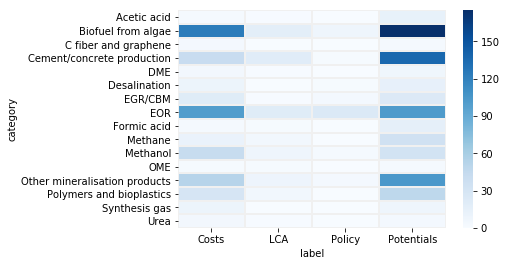

In [9]:
df = ldf.pivot(index="category",columns="label",values="ndocs")
import seaborn as sns
ax = sns.heatmap(
    df,cmap="Blues",
    #square=True,
    linecolor="#F0F0F0",
    linewidths=1
)

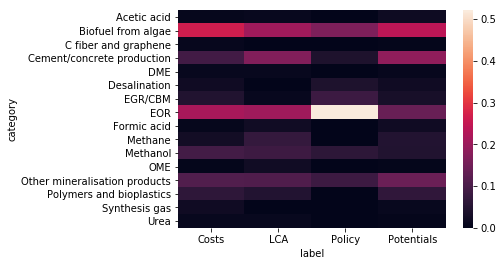

In [30]:
## Perhaps we want to show category scores as a percentage of each label
ldf['label_share'] = ldf['ndocs'] / ldf.label.map(ldf.groupby('label')['ndocs'].sum())
df = ldf.pivot(index="category",columns="label",values="label_share")#.reset_index()
# Here's the map showing the category-topic score as a share of that topics total scores
import seaborn as sns
ax = sns.heatmap(df)

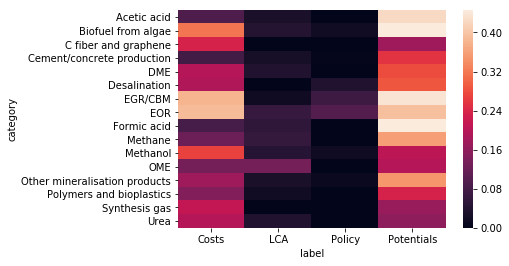

In [31]:
## Here the label is a fraction of the total docs in each category
ldf['cat_share'] = ldf['ndocs'] / ldf['total_docs']
df = ldf.pivot(index="category",columns="label",values="cat_share")#.reset_index()
# Here's the map showing the category-topic score as a share of that topics total scores
import seaborn as sns
ax = sns.heatmap(df)